# EOF analysis on data with monthly SST anomalies 

The first half of this notebook will introduce you to numpy [masked arrays](https://docs.scipy.org/doc/numpy/reference/maskedarray.html).

The second half will discuss some methods for creating EOFs.  This notebook will likely be modified and placed into the **week8** directory next week.

To ensure that other packages from previous weeks don't affect your ability to run this full notebook, we recommend you create a clean conda environment using instructions from the week7 [install-for-next-week](https://github.com/bairdlangenbrunner/ESS-Python-Tutorial/blob/master/materials/week7/0-install-for-next-week.ipynb) notebook.

From there, activate that environment (```conda activate my-eofs``` or ```source activate my-eofs```) and re-open this notebook from *that* terminal shell.

---

This notebook will use the PCA function within scikit-learn, there's a rich set of other things you can do as well.  
For a nice graphic summary: 
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt # note, this is often imported as "plt"
import pandas as pd # for 2D tables like csv and text files
import xarray as xr
import cartopy

In [2]:
SST_filename = '../data/HadISST_regridded_sst_195001-201412.nc' # gpcp data set

ncfile = xr.open_dataset(SST_filename)

ncfile

<xarray.Dataset>
Dimensions:           (bound: 2, latitude: 90, longitude: 180, time: 780)
Coordinates:
  * time              (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * latitude          (latitude) float64 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * longitude         (longitude) int32 1 3 5 7 9 11 ... 349 351 353 355 357 359
Dimensions without coordinates: bound
Data variables:
    bounds_time       (time, bound) datetime64[ns] ...
    bounds_latitude   (latitude, bound) float64 ...
    bounds_longitude  (longitude, bound) float64 ...
    sst               (time, latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.0
    comment:                    Data restrictions: for academic research use ...
    description:                HadISST 1.1 monthly average sea surface tempe...
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Title:                      Monthly version of HadISST sea surface temper..

**Open the full data set (global)**  
Remember:  the ```.values``` syntax returns the given variable as a numpy array.

In [3]:
SST_data = ncfile['sst'].values
SST_lat = ncfile['latitude'].values
SST_lon = ncfile['longitude'].values

**Take the time mean (across the first axis, ```axis=0```):**

In [4]:
SST_tmean = np.mean(SST_data, axis=0)

## Plotting the data

**Let's first plot the time-mean map to make sure it looks like we'd expect:**

Text(0.5, 1.0, 'Time-mean SST from HadISST (1960-2014)')

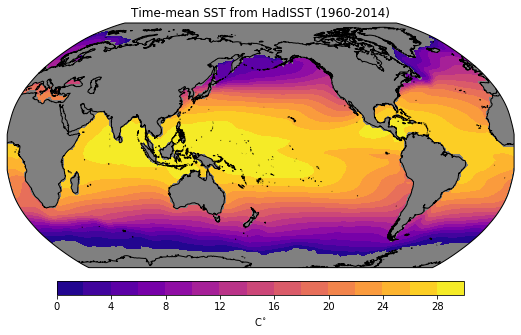

In [5]:
#1: specify projection info
map_crs = cartopy.crs.Robinson(central_longitude=180.)
data_crs = cartopy.crs.PlateCarree()

#2: create figure and axes objects
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=map_crs)

#3: add coastlines
ax.coastlines(resolution='50m') # res can be '110m', '50m', or '10m'
ax.background_patch.set_facecolor('gray')

#3: add contour level information and plot syntax
contour_levels = np.arange(0,30.1,2)

contour_plot = ax.contourf(SST_lon, 
                           SST_lat, 
                           SST_tmean,  
                           cmap='plasma',
                           levels=contour_levels,
                           transform=data_crs)

# contour_lines = ax.contour(SST_lon,
#                            SST_lat,
#                            SST_tmean,
#                            levels=contour_levels,
#                            transform=data_crs,
#                            linewidths=[0.5],
#                            colors=['0.1'])

#4: add final touches:  color bars, titles
cbar = fig.colorbar(contour_plot, orientation='horizontal', fraction=.05, aspect=30, pad=.05)
cbar.set_label('C$^{\circ}$')
ax.set_title('Time-mean SST from HadISST (1960-2014)')

## Select Tropical domain

Use the ```.sel()``` funcionality within ```xarray``` to pull out desired lat/lon ranges:

In [6]:
sst_data_tropic = ncfile['sst'].sel(latitude=slice(-40,40)).values
sst_lat_tropic = ncfile['latitude'].sel(latitude=slice(-40,40)).values
sst_lon_tropic = ncfile['longitude'].values

In [7]:
sst_data_tropic.shape

(780, 40, 180)

In [8]:
sst_data_tropic_Tmean = np.mean(sst_data_tropic, axis=0)

Text(0.5, 1.0, 'Time-mean Tropical SST from HadISST (1960-2014)')

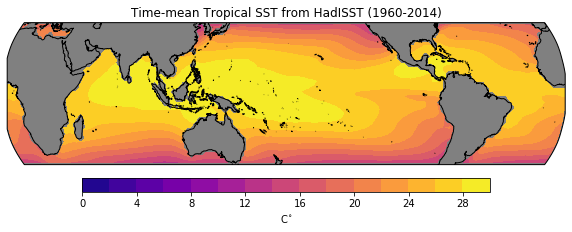

In [9]:
#1: specify projection info
map_crs = cartopy.crs.Robinson(central_longitude=180.)
data_crs = cartopy.crs.PlateCarree()

#2: create figure and axes objects
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=map_crs)

#3: add coastlines
ax.coastlines(resolution='50m') # res can be '110m', '50m', or '10m'
ax.background_patch.set_facecolor('gray')

#3: add contour level information and plot
contour_levels = np.arange(0,30.1,2)

contour_plot = ax.contourf(sst_lon_tropic, 
                           sst_lat_tropic, 
                           sst_data_tropic_Tmean,  
                           cmap='plasma',
                           levels=contour_levels,
                           transform=cartopy.crs.PlateCarree())

ax.set_extent([0, 359, -40, 40], crs=cartopy.crs.PlateCarree())

#4: add final touches:  color bars, titles
cbar = fig.colorbar(contour_plot, orientation='horizontal', fraction=.05, aspect=30, pad=.05)
cbar.set_label('C$^{\circ}$')
ax.set_title('Time-mean Tropical SST from HadISST (1960-2014)')

In [10]:
sst_data_tropic.shape

(780, 40, 180)

## Load SST anomalies dataset and reshape the data

In [12]:
SSTanom_filename = '../data/HadISST_regridded_sstanom_195001-201412.nc' # data set of SST anomalies
ncfile2 = xr.open_dataset(SSTanom_filename)

In [12]:
sst_data_tropic_anom = ncfile2['anom'].sel(latitude=slice(-40,40)).values
sst_lat_tropic = ncfile2['latitude'].sel(latitude=slice(-40,40)).values
sst_lon_tropic = ncfile2['longitude'].values

**Now, before we apply the EOF analysis to the data, we want to reshape the dataset to a 2D array with dimensions of ```[time, space]```:**

In [13]:
X_temporary = np.reshape(sst_data_tropic_anom,
                         (sst_data_tropic.shape[0],
                          sst_data_tropic.shape[1]*sst_data_tropic.shape[2]),
                         order='F')

**Using a ```-1``` in the ```.reshape()``` dimensionality argument also accomplishes this task.  A ```-1``` allows numpy to calculate the shape of the leftover dimension:**

    X_temporary = np.reshape(sst_data_tropic_anom,
                             (sst_data_tropic.shape[0],
                              -1),
                             order='F')

**Now, the land data will likely be NaNs. So let's check whether there are any NaNs:**

In [14]:
np.any(np.isnan(X_temporary))

True

**Yes, there are NaNs within the data. We want to mask out these variables, so let's first check the type of our data:**

In [15]:
type(X_temporary)

numpy.ndarray

## Retrieving the ocean-only data points

**The following steps will retrieve the ocean only points from our existing 2D array.  They use the [masked array](https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html) module, a very useful option within numpy.**

In [16]:
X = np.ma.masked_array(X_temporary, mask=np.isnan(X_temporary)) # Mask parts that are NaN

**Compare the types of the masked versus original array:**

In [17]:
print(type(sst_data_tropic))
print(type(X))

<class 'numpy.ndarray'>
<class 'numpy.ma.core.MaskedArray'>


In [18]:
X.shape

(780, 7200)

**We've now created a masked array data type.**  
Access the underlying data using the ```.data``` attributed.

In the plot below, each white line represents a latitude/longitude grid point with ocean:

Text(0.5, 0, 'space')

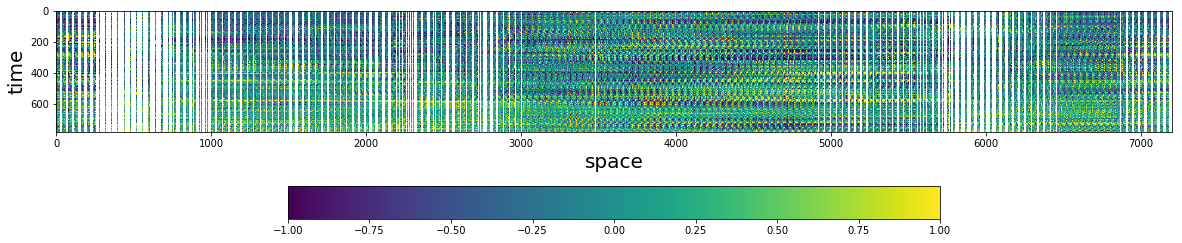

In [19]:
plt.imshow(X.data, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal', pad=0.25)
plt.gcf().set_size_inches(20,4)
plt.ylabel('time', fontsize=20)
plt.xlabel('space', fontsize=20)

Text(0.5, 0, 'space')

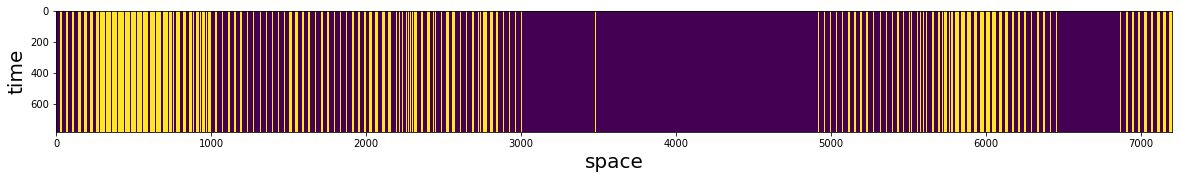

In [20]:
plt.imshow(X.mask)
plt.gcf().set_size_inches(20,4)
plt.ylabel('time', fontsize=20)
plt.xlabel('space', fontsize=20)

**Take a sum across the time dimension (```axis=0```):**

In [21]:
land = X.sum(axis=0).mask

**This makes an array with ```True``` where land exists and ```False``` where ocean exists:**

In [22]:
print(land.shape)
print(type(land))

(7200,)
<class 'numpy.ndarray'>


**The ```land``` array is a ```numpy.ndarray```**


Text(0.5, 0, 'space')

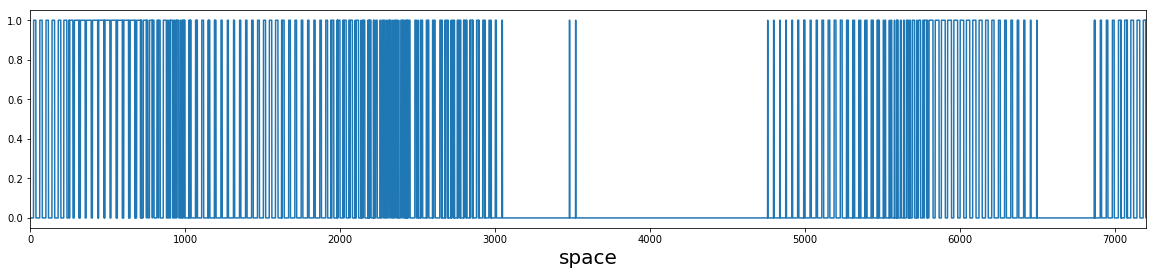

In [23]:
plt.plot(np.arange(land.size), land)
plt.gcf().set_size_inches(20,4)
plt.xlim(0,land.size)
plt.xlabel('space', fontsize=20)

**Create an array called ```ocean``` with ```True``` and ```False``` reversed from those of land:**

In [24]:
ocean = ~land

**Subset the ```X``` array using only ocean grid points:**

In [25]:
X=X[:,ocean]

**Let's check to see if there's any NaN data left.**

In [26]:
np.any(np.isnan(X))

False

---

# STOP HERE FOR WEEK 7

## Correction (3/13/19): We will not standardize the SST anomalies because we want to retain the structure in the standard deviation field





---

## Standardize the SST using the fit and transform methods

**These steps will help later on when you transform the data to normalize your dataset (make the mean = 0 and standard deviation = 1).**

In [27]:
#from sklearn import preprocessing
#scaler  = preprocessing.StandardScaler()

In [28]:
#scaler_sst = scaler.fit(X)

### Now, save the scaler object as a pickle

You can think of the pickle as a compressed form of the model and numpy array that you can retrieve at a later time. This makes it easier to retrieve the standardized array later without rerunning everything and is particularly important if the StandardScaler operation takes time to run. 

In [29]:
#from sklearn.externals import joblib

In [30]:
#joblib.dump(scaler_sst, './scaler_sst.pkl', compress=9) #save the scaler fit using 

['./scaler_sst.pkl']

In [31]:
#scaler_sst = joblib.load('./scaler_sst.pkl') #load the pickle

## Use the ``transform`` method of the scaler object

Actually retrieve the array where the mean and standard deviations have been normalized.

In [32]:
#X = scaler_sst.transform(X)

In [33]:
#X.mean()

-3.9659558406726997e-19

In [34]:
#X.std()

0.9999999999999999

In [35]:
#X.shape

(780, 5237)

## End of correction

---

## Now let's do the EOF decomposition using the PCA function

### What does PCA stand for? Principal component analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

In [36]:
from sklearn.decomposition import pca #import the principal component analysis function

In [37]:
skpca = pca.PCA() #treat the function as an object

In [38]:
skpca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
joblib.dump(skpca, './EOF.pkl', compress=9) #Save the model as another pickle for easy retrieval later

['./EOF.pkl']

## Plot the variance explained by the first 10 EOFS

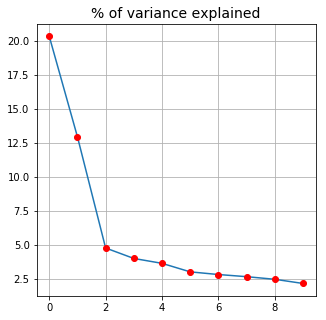

In [40]:
f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()

## Keep those that explain 70% of the variance

In [41]:
ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.70)[0][0]

In [42]:
ipc

16

### The Principal Components (PCs) are obtained by using the transform method of the pca object (skpca)

In [43]:
PCs = skpca.transform(X)

In [44]:
PCs = PCs[:,:ipc]

### The Empirical Orthogonal Functions (EOFs) are contained in the components_ attribute of the pca object (skpca)

In [45]:
EOFs = skpca.components_

In [46]:
EOFs = EOFs[:ipc,:]

In [47]:
EOFs.shape

(16, 5237)

## Let's reconstruct the 2D field maps

In [48]:
EOF_recons = np.ones((ipc, len(sst_lat_tropic) * len(sst_lon_tropic))) * -999.

In [49]:
for i in range(ipc): 
    EOF_recons[i,ocean] = EOFs[i,:]

In [50]:
EOF_recons = np.ma.masked_values(np.reshape(EOF_recons, (ipc, len(sst_lat_tropic), len(sst_lon_tropic)), order='F'), -999.)

In [51]:
EOF_recons.shape

(16, 40, 180)

In [52]:
type(EOF_recons)

numpy.ma.core.MaskedArray

In [53]:
EOF_recons=EOF_recons*100.

Text(0.5, 1.0, 'EOF1 of Tropical SST from HadISST (1960-2014)')

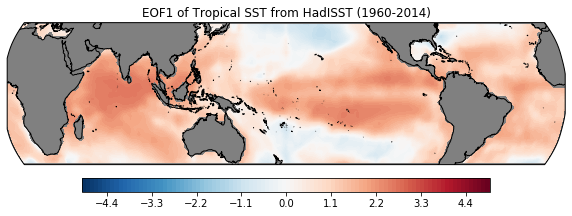

In [54]:
#1: specify projection info
map_crs = cartopy.crs.Robinson(central_longitude=180.)
data_crs = cartopy.crs.PlateCarree()

#2: create figure and axes objects
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=map_crs)

#3: add coastlines
ax.coastlines(resolution='50m') # res can be '110m', '50m', or '10m'
ax.background_patch.set_facecolor('gray')

#3: add contour level information and plot
contour_levels = np.arange(-5,5.1,0.1)

contour_plot = ax.contourf(sst_lon_tropic, 
                           sst_lat_tropic,
                           EOF_recons[0,:,:],  
                           cmap='RdBu_r',
                           levels=contour_levels,
                           transform=data_crs)

ax.set_extent([0, 359, -40, 40], crs=cartopy.crs.PlateCarree())

#4: add final touches:  color bars, titles
cbar = fig.colorbar(contour_plot, orientation='horizontal', fraction=.05, aspect=30, pad=.05)
ax.set_title('EOF1 of Tropical SST from HadISST (1960-2014)')

Text(0.5, 1.0, 'EOF2 of Tropical SST from HadISST (1960-2014)')

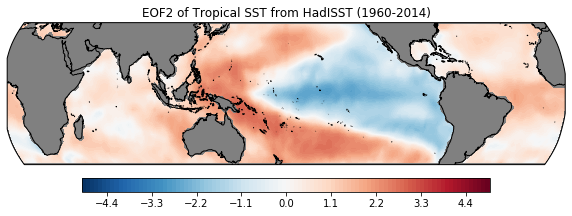

In [55]:
#1: specify projection info
map_crs = cartopy.crs.Robinson(central_longitude=180)
data_crs = cartopy.crs.PlateCarree()

#2: create figure and axes objects
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=map_crs)

#3: add coastlines
ax.coastlines(resolution='50m') # res can be '110m', '50m', or '10m'
ax.background_patch.set_facecolor('gray')

#3: add contour level information and plot
contour_levels = np.arange(-5,5.1,0.1)

contour_plot = ax.contourf(sst_lon_tropic, 
                           sst_lat_tropic, 
                           EOF_recons[1,:,:],  
                           cmap='RdBu_r',
                           levels=contour_levels,
                           transform=data_crs)

ax.set_extent([0, 359, -40, 40], crs=cartopy.crs.PlateCarree())

#4: add final touches:  color bars, titles
cbar = fig.colorbar(contour_plot, orientation='horizontal', fraction=.05, aspect=30, pad=.05)
ax.set_title('EOF2 of Tropical SST from HadISST (1960-2014)')

Text(0.5, 1.0, 'EOF3 of Tropical SST from HadISST (1960-2014)')

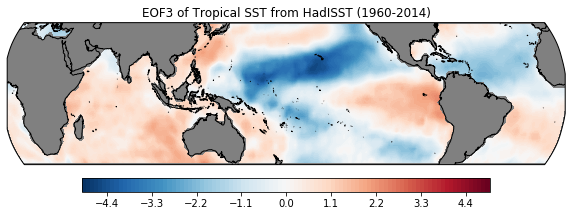

In [56]:
#1: specify projection info
map_crs = cartopy.crs.Robinson(central_longitude=180)
data_crs = cartopy.crs.PlateCarree()

#2: create figure and axes objects
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=map_crs)

#3: add coastlines
ax.coastlines(resolution='50m') # res can be '110m', '50m', or '10m'
ax.background_patch.set_facecolor('gray')

#3: add contour level information and plot
contour_levels = np.arange(-5,5.1,0.1)

contour_plot = ax.contourf(sst_lon_tropic, 
                           sst_lat_tropic, 
                           EOF_recons[2,:,:],  
                           cmap='RdBu_r',
                           levels=contour_levels,
                           transform=data_crs)

ax.set_extent([0, 359, -40, 40], crs=cartopy.crs.PlateCarree())

#4: add final touches:  color bars, titles
cbar = fig.colorbar(contour_plot, orientation='horizontal', fraction=.05, aspect=30, pad=.05)
ax.set_title('EOF3 of Tropical SST from HadISST (1960-2014)')

## Let's get the Principal components

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler_PCs = StandardScaler()

In [59]:
scaler_PCs.fit(PCs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [60]:
PCs_std = scaler_PCs.transform(PCs)

In [61]:
joblib.dump(scaler_PCs, './scaler_PCs.pkl')

['./scaler_PCs.pkl']

In [62]:
time_pd=ncfile['time']

In [63]:
time_values = time_pd.values
time_values_converted = pd.to_datetime(time_values)

In [64]:
PCdf = pd.DataFrame(PCs_std, index = time_values_converted, \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])

In [65]:
PCdf.head()

,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9,EOF10,EOF11,EOF12,EOF13,EOF14,EOF15,EOF16
1950-01-16 12:00:00,-1.288673,0.043419,0.559119,-0.541621,-1.422223,0.909827,-0.149868,-0.674025,0.223624,1.706110,0.720287,-0.622546,-0.589526,1.027212,-0.376686,-0.005702
1950-02-15 00:00:00,-1.663971,0.402155,0.458620,-0.513424,-2.347102,0.503158,-0.828204,-1.403542,-1.155719,1.021672,1.069200,-0.289907,0.111890,1.451413,1.003363,0.160929
1950-03-16 12:00:00,-1.455537,0.444750,0.890914,-0.129548,-1.416250,0.595874,-0.167906,-0.516248,-1.077230,0.420686,0.985082,0.641921,-0.668100,1.605604,0.866666,-0.677064
1950-04-16 00:00:00,-1.591354,0.306027,0.094192,-0.263872,-0.608099,0.596182,-0.223613,-0.677280,-1.318396,0.446240,0.723964,1.050595,-1.240230,1.121314,-0.098609,-1.412366
1950-05-16 12:00:00,-1.843309,0.283260,0.387100,-0.032311,0.078963,1.916372,0.356553,-0.484319,-1.236295,0.807444,1.101128,-0.225917,-0.861346,0.779411,-0.258403,0.438935


/Users/baird/miniconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PC1')

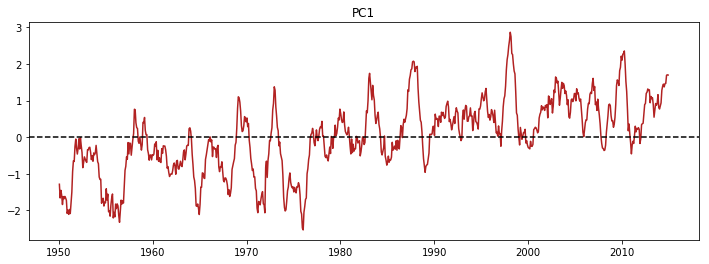

In [66]:
# create a "figure object"
fig = plt.figure(figsize=(12,4)) # 12 inches wide, 4 inches tall

# add an axes object to the figure
ax = fig.add_subplot(1,1,1) # rows, columns, current figure

# use that axes object to plot
ax.plot(time_values_converted, PCdf.iloc[:,0].values, c='firebrick')

# add horizontal lines at 0 and ±1 stdev
ax.axhline(0, ls='--', c='black')
ax.set_title('PC1')
#ax.axhline(nino34_data_std, c='gray')
#ax.axhline(-nino34_data_std, c='gray')

Text(0.5, 1.0, 'PC2')

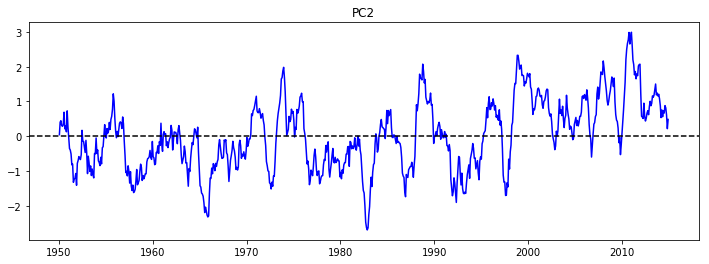

In [67]:
# create a "figure object"
fig = plt.figure(figsize=(12,4)) # 12 inches wide, 4 inches tall

# add an axes object to the figure
ax = fig.add_subplot(1,1,1) # rows, columns, current figure

# use that axes object to plot
ax.plot(time_values_converted, PCdf.iloc[:,1].values, c='blue')

# add horizontal lines at 0 and ±1 stdev
ax.axhline(0, ls='--', c='black')
ax.set_title('PC2')
#ax.axhline(nino34_data_std, c='gray')
#ax.axhline(-nino34_data_std, c='gray')

## Now, how do these PCs compare with the El Nino 3.4 index we looked at in an earlier class?

In [68]:
nino_index_data = np.loadtxt('../data/ersst4.nino.mth.81-10.ascii.txt', skiprows=1)
print(nino_index_data)
print(nino_index_data.shape)

[[ 1.950e+03  1.000e+00  2.330e+01 ... -1.170e+00  2.491e+01 -1.800e+00]
 [ 1.950e+03  2.000e+00  2.433e+01 ... -1.370e+00  2.526e+01 -1.620e+00]
 [ 1.950e+03  3.000e+00  2.524e+01 ... -1.410e+00  2.608e+01 -1.280e+00]
 ...
 [ 2.016e+03  1.000e+00  2.621e+01 ...  1.110e+00  2.895e+01  2.240e+00]
 [ 2.016e+03  2.000e+00  2.730e+01 ...  1.190e+00  2.889e+01  2.020e+00]
 [ 2.016e+03  3.000e+00  2.747e+01 ...  1.140e+00  2.900e+01  1.640e+00]]
(795, 10)


In [69]:
# first two columns are year and month
years = nino_index_data[:,0]
months = nino_index_data[:,1]

In [70]:
# ninth column is the Nino 3.4 index
nino34_data = nino_index_data[:,8]

In [71]:
import datetime

In [72]:
nino34_dates = [] # create empty list
for i in range(len(years)):
    # loop through each entry in years and months and create a date from them
    nino34_dates.append(datetime.date(year=int(years[i]), month=int(months[i]), day=15))

In [73]:
nino34_data_centered = nino34_data - np.mean(nino34_data)
nino34_data_std = np.std(nino34_data)

Text(0.5, 1.0, 'Comparing the Nino3.4 index and PC2')

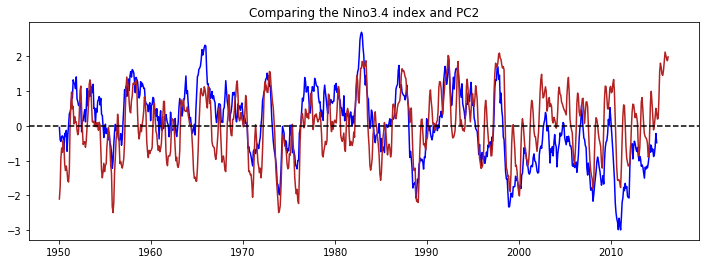

In [74]:
# create a "figure object"
fig = plt.figure(figsize=(12,4)) # 12 inches wide, 4 inches tall

# add an axes object to the figure
ax = fig.add_subplot(1,1,1) # rows, columns, current figure

# use that axes object to plot
ax.plot(time_values_converted, PCdf.iloc[:,1].values*-1., c='blue')

ax.plot(nino34_dates,nino34_data_centered,c='firebrick')

# add horizontal lines at 0 and ±1 stdev
ax.axhline(0, ls='--', c='black')
ax.set_title('Comparing the Nino3.4 index and PC2')
#ax.axhline(nino34_data_std, c='gray')
#ax.axhline(-nino34_data_std, c='gray')

Text(0.5, 1.0, 'PC3')

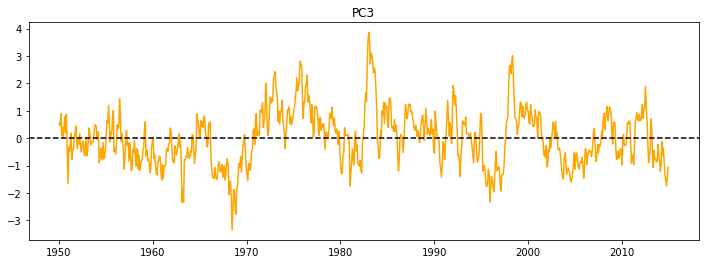

In [75]:
# create a "figure object"
fig = plt.figure(figsize=(12,4)) # 12 inches wide, 4 inches tall

# add an axes object to the figure
ax = fig.add_subplot(1,1,1) # rows, columns, current figure

# use that axes object to plot
ax.plot(time_values_converted, PCdf.iloc[:,2].values, c='orange')

# add horizontal lines at 0 and ±1 stdev
ax.axhline(0, ls='--', c='black')
ax.set_title('PC3')
#ax.axhline(nino34_data_std, c='gray')
#ax.axhline(-nino34_data_std, c='gray')